In [1]:
# !pip3 install matplotlib pandas seaborn
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from databuddy import get_data, get_votes, get_states

In [35]:
def construct_dataframe():

    data = get_data()
    states = get_states()
    votes2020 = get_votes(2020)

    # Remove states that have no data
    data = data[data.state.isin(states.index)]


    data["state_popn"] = data.state.map(lambda s: states.loc[s].Pop)
    data["state_name"] = data.state.map(lambda s: states.loc[s].State)
    
    # Remove states that aren't in the votes data
    data = data[data.state_name.str.upper().isin(votes2020.state)]

    votes2020 = votes2020.set_index("state")
    
    data["state_dem_votes"] = data.state_name.map(lambda s: votes2020.loc[s.upper().strip()].candidatevotes.DEMOCRAT)
    data["state_rep_votes"] = data.state_name.map(lambda s: votes2020.loc[s.upper().strip()].candidatevotes.REPUBLICAN)
    data["test_pos_state_popn"] = 100*data.tot_cases / data.state_popn
    data["new_case_state_popn"] = 100*data.new_case / data.state_popn
    data["death_pct_state_popn"] = 100*data.tot_death / data.state_popn

    return data

In [39]:
# data = construct_dataframe()

data["political_affiliation"] = data.state_dem_votes > data.state_rep_votes
data["political_affiliation"] = data.political_affiliation.map(lambda x: "D" if x else "R")

ValueError: Can only compare identically-labeled Series objects

In [65]:
votes2020.candidatevotes.sum()

party_simplified
DEMOCRAT      81268908
REPUBLICAN    74216146
dtype: int64

In [86]:
votes2020 = get_votes(2020)
votes2020.candidatevotes.sum()
votes2020['percD'] = [r.candidatevotes.DEMOCRAT / r.candidatevotes.sum() for i, r in votes2020.iterrows()]
votes2020['percR'] = [r.candidatevotes.REPUBLICAN / r.candidatevotes.sum() for i, r in votes2020.iterrows()]
states = get_states().reset_index()
votes2020 = votes2020[votes2020.state != "DISTRICT OF COLUMBIA"]
votes2020['state_abbr'] = (
    votes2020.state.map(lambda x: states[states.State.str.upper() == x.upper()].iloc[0].Postalcode)
)
votes2020['Pop'] = (
    votes2020.state.map(lambda x: states[states.State.str.upper() == x.upper()].iloc[0].Pop)
)

votes2020 = votes2020.set_index("state_abbr")

/var/folders/xb/l415c7qx7dz0d895wpxs4sc00000gp/T/ipykernel_32825/116820628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes2020['state_abbr'] = (
/var/folders/xb/l415c7qx7dz0d895wpxs4sc00000gp/T/ipykernel_32825/116820628.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes2020['Pop'] = (


In [100]:
votes2020

year           state candidatevotes                percD  \
party_simplified                             DEMOCRAT REPUBLICAN             
state_abbr                                                                   
AL                2020         ALABAMA         849624    1441170  0.370886   
AK                2020          ALASKA         153778     189951  0.447382   
AZ                2020         ARIZONA        1672143    1661686  0.501568   
AR                2020        ARKANSAS         423932     760647  0.357876   
CA                2020      CALIFORNIA       11110250    6006429  0.649089   
CO                2020        COLORADO        1804352    1364607  0.569383   
CT                2020     CONNECTICUT        1080831     714717  0.601950   
DE                2020        DELAWARE         296268     200603  0.596267   
FL                2020         FLORIDA        5297045    5668731  0.483052   
GA                2020         GEORGIA        2473633    2461854  0.501193   
HI                2020          HAWAII         366130     196864  0.650327   
ID                2020           IDAHO         287021     554119  0.341229   
IL                2020        ILLINOIS        3471915    2446891  0.586590   
IN                2020         INDIANA        1242416    1729519  0.418050   
IA                2020            IOWA         759061     897672  0.458167   
KS                2020          KANSAS         570323     771406  0.425066   
KY                2020        KENTUCKY         772474    1326646  0.367999   
LA                2020       LOUISIANA         856034    1255776  0.405356   
ME                2020           MAINE         435072     360737  0.546704   
MD                2020        MARYLAND        1985023     976414  0.670290   
MA                2020   MASSACHUSETTS        2382202    1167202  0.671155   
MI                2020        MICHIGAN        2804040    2649852  0.514136   
MN                2020       MINNESOTA        1717077    1484065  0.536395   
MS                2020     MISSISSIPPI         539398     756764  0.416150   
MO                2020        MISSOURI        1253014    1718736  0.421642   
MT                2020         MONTANA         244786     343602  0.416028   
NE                2020        NEBRASKA         374583     556846  0.402159   
NV                2020          NEVADA         703486     669890  0.512231   
NH                2020   NEW HAMPSHIRE         424921     365654  0.537483   
NJ                2020      NEW JERSEY        2608335    1883274  0.580713   
NM                2020      NEW MEXICO         501614     401894  0.555185   
NY                2020        NEW YORK        5230985    3244798  0.617168   
NC                2020  NORTH CAROLINA        2684292    2758773  0.493158   
ND                2020    NORTH DAKOTA         114902     235595  0.327826   
OH                2020            OHIO        2679165    3154834  0.459233   
OK                2020        OKLAHOMA         503890    1020280  0.330600   
OR                2020          OREGON        1340383     958448  0.583072   
PA                2020    PENNSYLVANIA        3458229    3377674  0.505892   
RI                2020    RHODE ISLAND         307486     199922  0.605994   
SC                2020  SOUTH CAROLINA        1091541    1385103  0.440734   
SD                2020    SOUTH DAKOTA         150471     261043  0.365652   
TN                2020       TENNESSEE        1143711    1852475  0.381722   
TX                2020           TEXAS        5259126    5890347  0.471693   
UT                2020            UTAH         560282     865140  0.393064   
VT                2020         VERMONT         242820     112704  0.682992   
VA                2020        VIRGINIA        2413568    1962430  0.551547   
WA                2020      WASHINGTON        2369612    1584651  0.599255   
WV                2020   WEST VIRGINIA         235984     545382  0.302015   
WI                2020       WISCONSIN  

In [88]:
# STATES = ["MD", "PA", "AL", "TX", "ND", "NY"]
STATE_COLORS = {
    # Nice hex colors spanning the spectrum
    "MD": "#8c564b",
    "PA": "#e377c2",
    "AL": "#7f7f7f",
    "TX": "#bcbd22",
    "ND": "#17becf",
    "NY": "#1f77b4",
}
 

In [89]:
len(data)

16552

In [92]:
# data.reset_index(inplace=True)

In [93]:
data = data[~pd.isna(data.tot_cases) & data.tot_cases > 0]

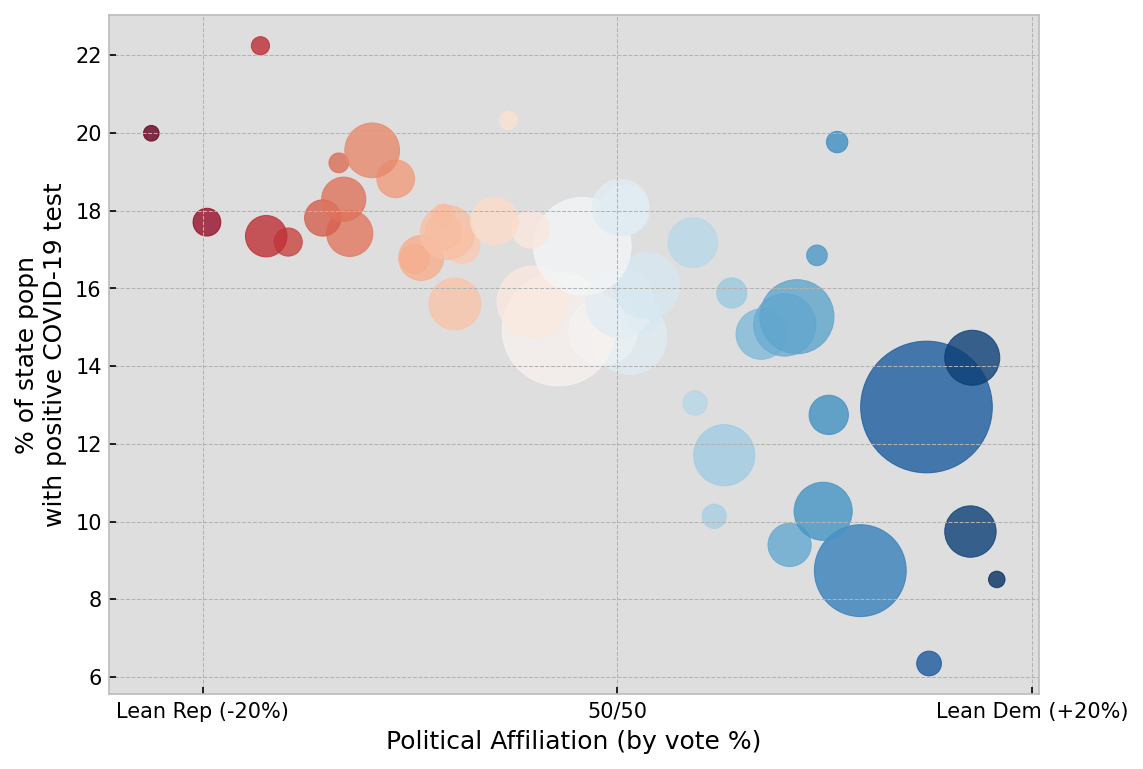

In [107]:
with plt.style.context("bmh"):
    plt.figure(figsize=(8, 6), dpi=150,)
    plt.gca().set_facecolor("#dedede")
    plt.scatter(
        data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes2020.loc[x].percD*100),
        data.groupby("state").test_pos_state_popn.max().sort_values(),
        c=data.groupby("state").test_pos_state_popn.max().sort_values().index.map(lambda x: votes2020.loc[x].percD*100),
        cmap='RdBu', marker='o', 
        s=[
            votes2020.loc[data.groupby("state").test_pos_state_popn.max().sort_values().index].Pop/10000
        ], 
        alpha=0.8
    )
    plt.xlabel("Political Affiliation (by vote %)")
    plt.ylabel("% of state popn\nwith positive COVID-19 test")
    plt.xticks([30, 50, 70], ["Lean Rep (-20%)", "50/50", "Lean Dem (+20%)"])

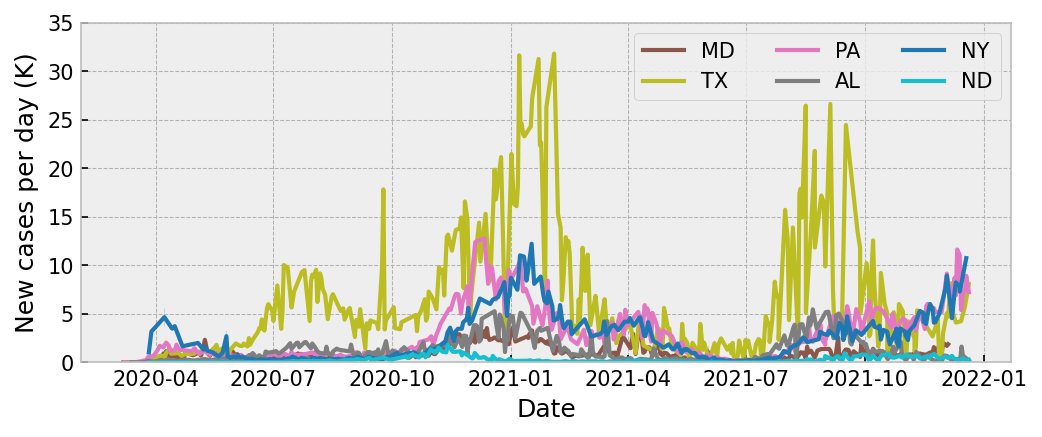

In [108]:
_plotting_data = data[data.state.isin(STATE_COLORS)]
_plotting_data = _plotting_data[_plotting_data.new_case > 0.001]

_plotting_labels = _plotting_data.groupby("state").new_case.max()

with plt.style.context("bmh"):
    plt.figure(figsize=(8, 3), dpi=150)

    sns.lineplot(
        y='new_case',
        x='created_at',
        data=_plotting_data,
        hue="state",
        palette=STATE_COLORS,
    )
#     plt.yscale("log")
    leg = plt.legend(ncol=3)
    plt.yticks(plt.yticks()[0], [str(int(x/1000)) for x in plt.yticks()[0]])
    plt.ylim(0, max(plt.ylim()))
    plt.ylabel("New cases per day (K)")
    plt.xlabel("Date")

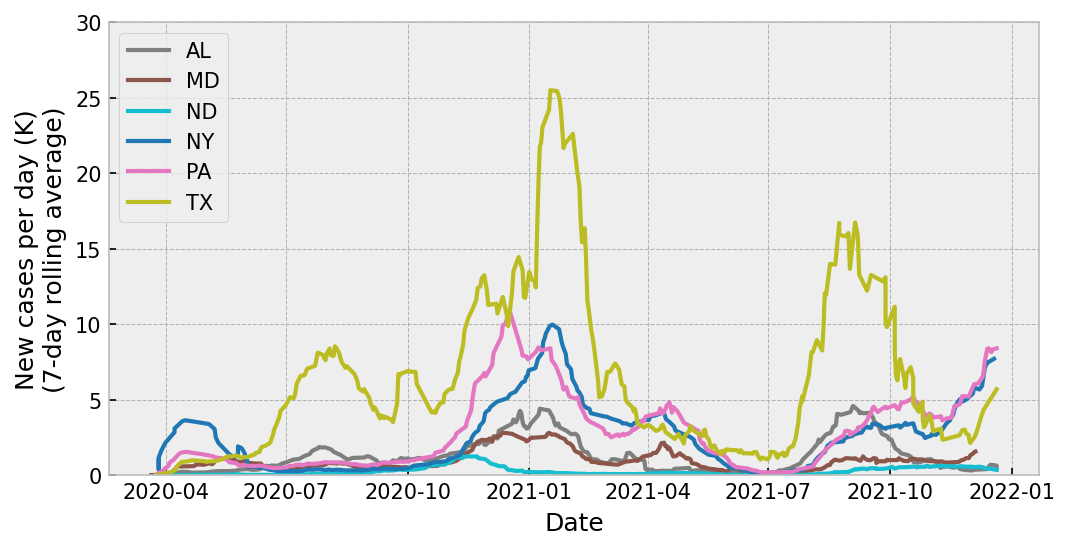

In [109]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    groups = _plotting_data.groupby('state')
    for k in sorted(STATE_COLORS.keys()):
        v = groups.get_group(k)
        # X is date
        # Y is rolling average of new cases over last 7 days
        X = v.created_at.values
        Y = v.new_case.rolling(7).mean().values
        ax.plot(X, Y, label=k, color=STATE_COLORS[k])

    plt.ylabel("New cases per day (K)\n(7-day rolling average)")
    # set y ticks to be in thousands (K)
    plt.yticks(plt.yticks()[0], [str(int(x/1000)) for x in plt.yticks()[0]])
    plt.ylim(0, max(plt.ylim()))
    plt.xlabel("Date")
    plt.legend(loc='upper left')


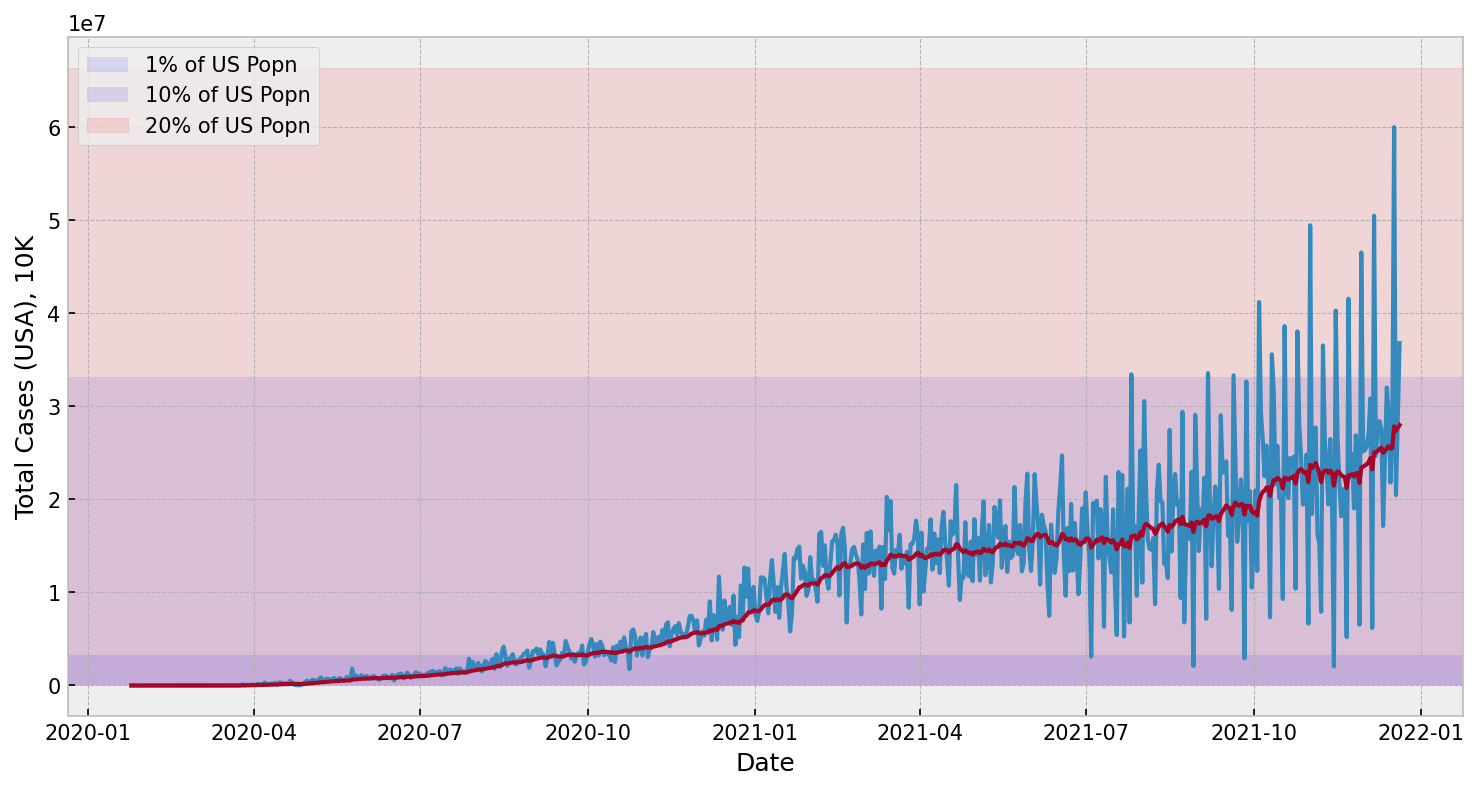

In [110]:
_d = data.groupby(data.created_at.dt.date).sum()

POPN_ESTIMATE = 332_000_000

with plt.style.context("bmh"):
    plt.figure(figsize=(12, 6), dpi=150)
    sns.lineplot(x='created_at', y=_d.tot_cases, data=_d, )
    sns.lineplot(x='created_at', y=_d.tot_cases.ewm(14).mean(), data=_d)
    plt.xlabel("Date")
    plt.ylabel("Total Cases (USA), 10K")
    
    plt.axhspan(0, POPN_ESTIMATE*0.01, alpha=0.1, label="1% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.1, alpha=0.1, label="10% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.2, alpha=0.1, color='r', label="20% of US Popn")
    plt.legend()
#     plt.yscale("log")